In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.model.mlm.pet_for_text_classification import train 
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "PET"
dataset_name = "RAFT-TWITTER-EMOTION"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Loading dataset

In [4]:
dataset = load_dataset(
    "tweet_eval", 
    name= "emotion",
    cache_dir= "/Data/pedro.silva"
)

In [5]:
classes = np.unique(dataset['train']['label'], return_counts=True)
classes

(array([0, 1, 2, 3]), array([1400,  708,  294,  855]))

In [6]:
.7
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning study - 50 shots

In [7]:
classes = np.unique(dataset['train']['label'], return_counts=True)
train_validation, test_df = stratified_train_test_split(
    dataset['train'],
    classes,
    train_size = 50
)

In [8]:
train_df, val_df  = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [9]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [10]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{text} The previous text refers to anger, joy, optimism or sadness ? {tokenizer.mask_token}"

In [11]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
class_names = ["anger", "joy", "optimism", "sadness"]

idx2class = {i : v for i,v in enumerate(class_names)}

class2idx = {v:i for i, v in enumerate(class_names)}


verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [12]:
verbalizer

{0: 4963, 1: 6569, 2: 27451, 3: 12039}

In [13]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [14]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [15]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [16]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

31it [00:00, 99.75it/s] 
19it [00:00, 107.62it/s]
1000it [00:09, 104.27it/s]


In [17]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [18]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([ 2.38461538,  4.42857143, 10.33333333,  3.875     ]),
 array([2.375, 4.75 , 9.5  , 3.8  ]),
 array([ 2.42130751,  4.58715596, 11.23595506,  3.57142857]))

In [19]:
from src.utils import FocalLoss

In [20]:
classes

(array([0, 1, 2, 3]), array([1400,  708,  294,  855]))

In [29]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-6,
    lr=1e-4,
    evaluation_fn= multiclass_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=10
)

Epoch 19
f1-score : 0.4210526645183563
tensor([[3, 0, 0, 5],
        [1, 0, 0, 3],
        [1, 0, 0, 1],
        [0, 0, 0, 5]], device='cuda:0')


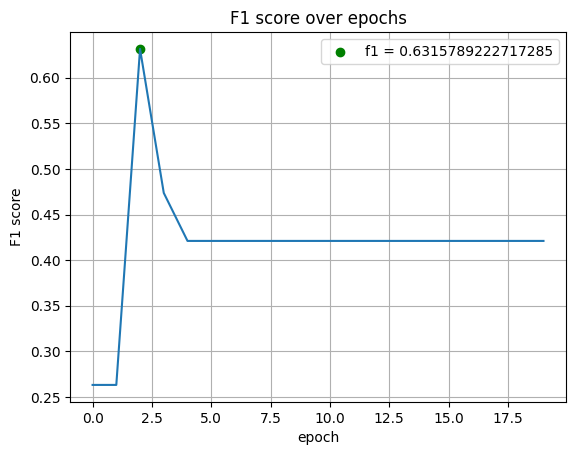

In [30]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-TWITTER-EMOTION - PET')

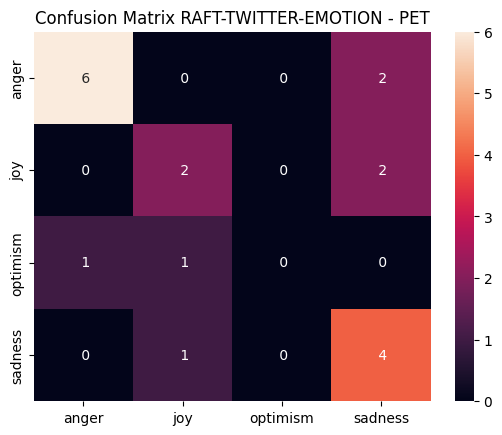

In [31]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [32]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [33]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(classes[0])
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 109.72it/s]


In [34]:
f1

tensor(0.6480, device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix RAFT-TWITTER-EMOTION - PET')

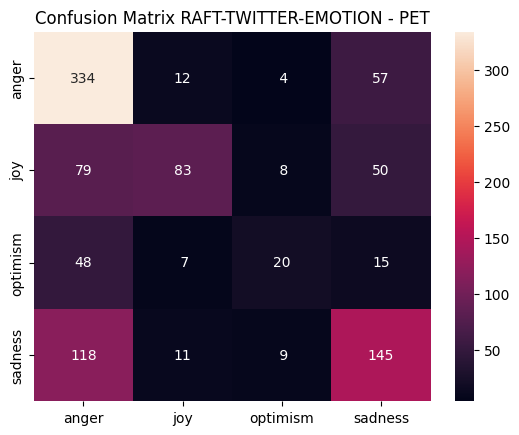

In [37]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_test.to(torch.int64),
    y_true_test.to(torch.int64),
    num_classes= len(classes[0])
)

df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## General approach - 500 shots

In [35]:
classes = np.unique(dataset['train']['label'], return_counts=True)
n_shots = 500
train_validation, test_df = stratified_train_test_split(
    dataset['train'],
    classes,
    train_size = n_shots
)

In [36]:
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [37]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [38]:
def pattern1(text: str, tokenizer : AutoTokenizer):
    return f"{text} The previous text refers to anger, joy, optimism or sadness ? {tokenizer.mask_token}"

In [39]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",
                                          cache_dir = "/Data/pedro.silva")
class_names = ["anger", "joy", "optimism", "sadness"]

idx2class = {i : v for i,v in enumerate(class_names)}

class2idx = {v:i for i, v in enumerate(class_names)}


verbalizer = {idx : tokenizer.vocab[x.lower()] for idx, x in enumerate(class_names)}
inverse_verbalizer = {tokenizer.vocab[x.lower()] : idx for idx, x in enumerate(class_names)}

In [40]:
verbalizer

{0: 4963, 1: 6569, 2: 27451, 3: 12039}

In [41]:

def preprocess(text : List[str], labels : List[int]):

    processed_text = []
    processed_labels = []
    for idx in range(len(text)):
        label = idx2class[labels[idx]]
        text_ = text[idx]

        processed_text.append(pattern1(text_, tokenizer))
        processed_labels.append(label)

    return processed_text, processed_labels

In [42]:
train_text, train_labels = preprocess(train_df['text'], train_df['label'])
val_text, val_labels = preprocess(val_df['text'], val_df['label'])
test_text, test_labels = preprocess(test_df['text'], test_df['label'])

In [43]:
class PETDatasetForClassification(Dataset):
    def __init__(
        self, 
        processed_text : List[str], 
        labels : List[int],
        tokenizer : AutoTokenizer,
        device : str = "cuda"
    ) -> None:
        super().__init__()

        self.tokens = tokenizer(
            processed_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        self.encoded_labels = deepcopy(self.tokens['input_ids'])
        
        self.encoded_labels[self.encoded_labels != tokenizer.mask_token_id] = -100

        for idx, sentence in tqdm(enumerate(self.encoded_labels)):
            sentence[sentence == tokenizer.mask_token_id] = tokenizer.vocab[labels[idx].lower()]

        self.inputs : Dict[str, torch.Tensor] = self.tokens
        self.inputs['labels'] = self.encoded_labels

        for k,v in self.inputs.items():
            self.inputs[k] = v.to(device)

    def __getitem__(self, index):
        d : Dict = dict()
        for key in self.inputs.keys():
            d[key] = self.inputs[key][index]

        return d
    
    def __len__(self):
        return self.tokens['input_ids'].shape[0]

In [44]:
train_dataset = PETDatasetForClassification(
    train_text,
    train_labels,
    tokenizer
)

val_dataset = PETDatasetForClassification(
    val_text,
    val_labels,
    tokenizer
)

test_dataset = PETDatasetForClassification(
    test_text,
    test_labels,
    tokenizer
)

300it [00:02, 105.85it/s]
200it [00:01, 102.93it/s]
1000it [00:09, 104.67it/s]


In [45]:
train_dataloader = DataLoader(train_dataset, shuffle= True)
val_dataloader =DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [46]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val_df['label'],
    return_counts=True,
)
alpha_val = len(val_df['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test_df['label'],
    return_counts=True,
)
alpha_test = len(test_df['label'])/class_counts_test
alpha, alpha_val, alpha_test

(array([ 2.3255814 ,  4.61538462, 11.11111111,  3.79746835]),
 array([ 2.3255814 ,  4.54545455, 11.11111111,  3.84615385]),
 array([ 2.34192037,  4.29184549, 10.63829787,  4.06504065]))

In [47]:
from src.utils import FocalLoss

In [48]:
classes

(array([0, 1, 2, 3]), array([1400,  708,  294,  855]))

In [50]:
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased",
                                             cache_dir = "/Data/pedro.silva").to(device)
history, confusion_matrix, best_model = train(
    train_dataloader,
    val_dataloader,
    num_classes = len(class_names),
    model = model,
    verbalizer = verbalizer,
    tokenizer=tokenizer,
    alpha = 1e-5,
    evaluation_fn= multiclass_f1_score,
    loss_fn=FocalLoss(alpha, gamma=1),
    n_epochs=20
)

Epoch 29
f1-score : 0.7449999451637268
tensor([[69,  6,  1, 10],
        [ 2, 37,  0,  5],
        [ 6,  3,  7,  2],
        [ 8,  7,  1, 36]], device='cuda:0')


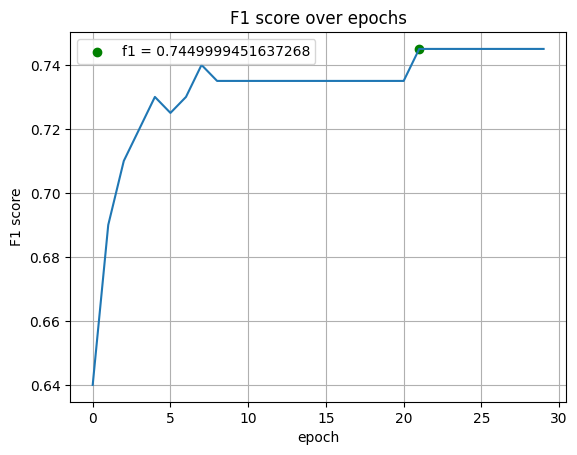

In [51]:
plt.plot(history)
plt.scatter(
    np.argmax(history),
    np.max(history),
    label = f"f1 = {np.max(history)}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend()

Text(0.5, 1.0, 'Confusion Matrix RAFT-TWITTER-EMOTION - PET')

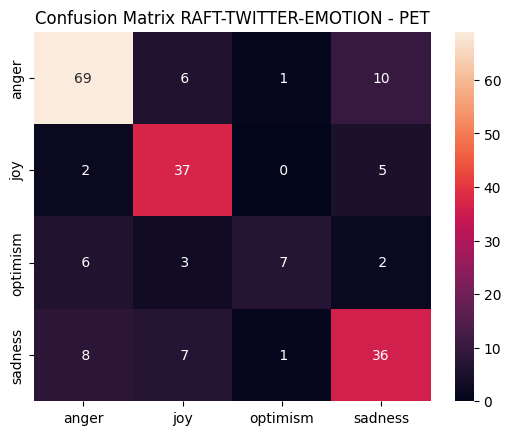

In [52]:
df = pd.DataFrame(
    confusion_matrix.to("cpu").numpy(),
    index = class_names,
    columns=class_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - PET")

## Test results

In [53]:
from src.model.mlm.pet_for_text_classification import get_y_true

In [54]:
with torch.no_grad():
    y_true_test = torch.tensor([],device=device)
    y_pred_test = torch.tensor([],device=device)

    for input in tqdm(test_dataloader):
        out = best_model(**input)

        y_true = get_y_true(
            input,
            inverse_verbalizer
        )

        try:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[1]

        except:
            mask_token_index = torch.where(input["input_ids"] == tokenizer.mask_token_id)[0]
        mask_token_logits = out.logits[0, mask_token_index, :]
        
        predictions = torch.Tensor(
            [mask_token_logits[0,x] for x in verbalizer.values()]
        )

        y_pred = predictions.argmax().to(device)

        y_pred_test = torch.cat([
            y_pred_test, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_test = torch.cat([
            y_true_test,
            torch.tensor([y_true]).to(device)
        ])
    
    f1 = multiclass_f1_score(
        y_pred_test,
        y_true_test,
        num_classes= len(classes[0])
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 108.57it/s]


In [55]:
f1

tensor(0.7300, device='cuda:0')